In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)#.cuda()
model.eval()

Using cache found in /home/henistein/.cache/torch/hub/pytorch_vision_v0.10.0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

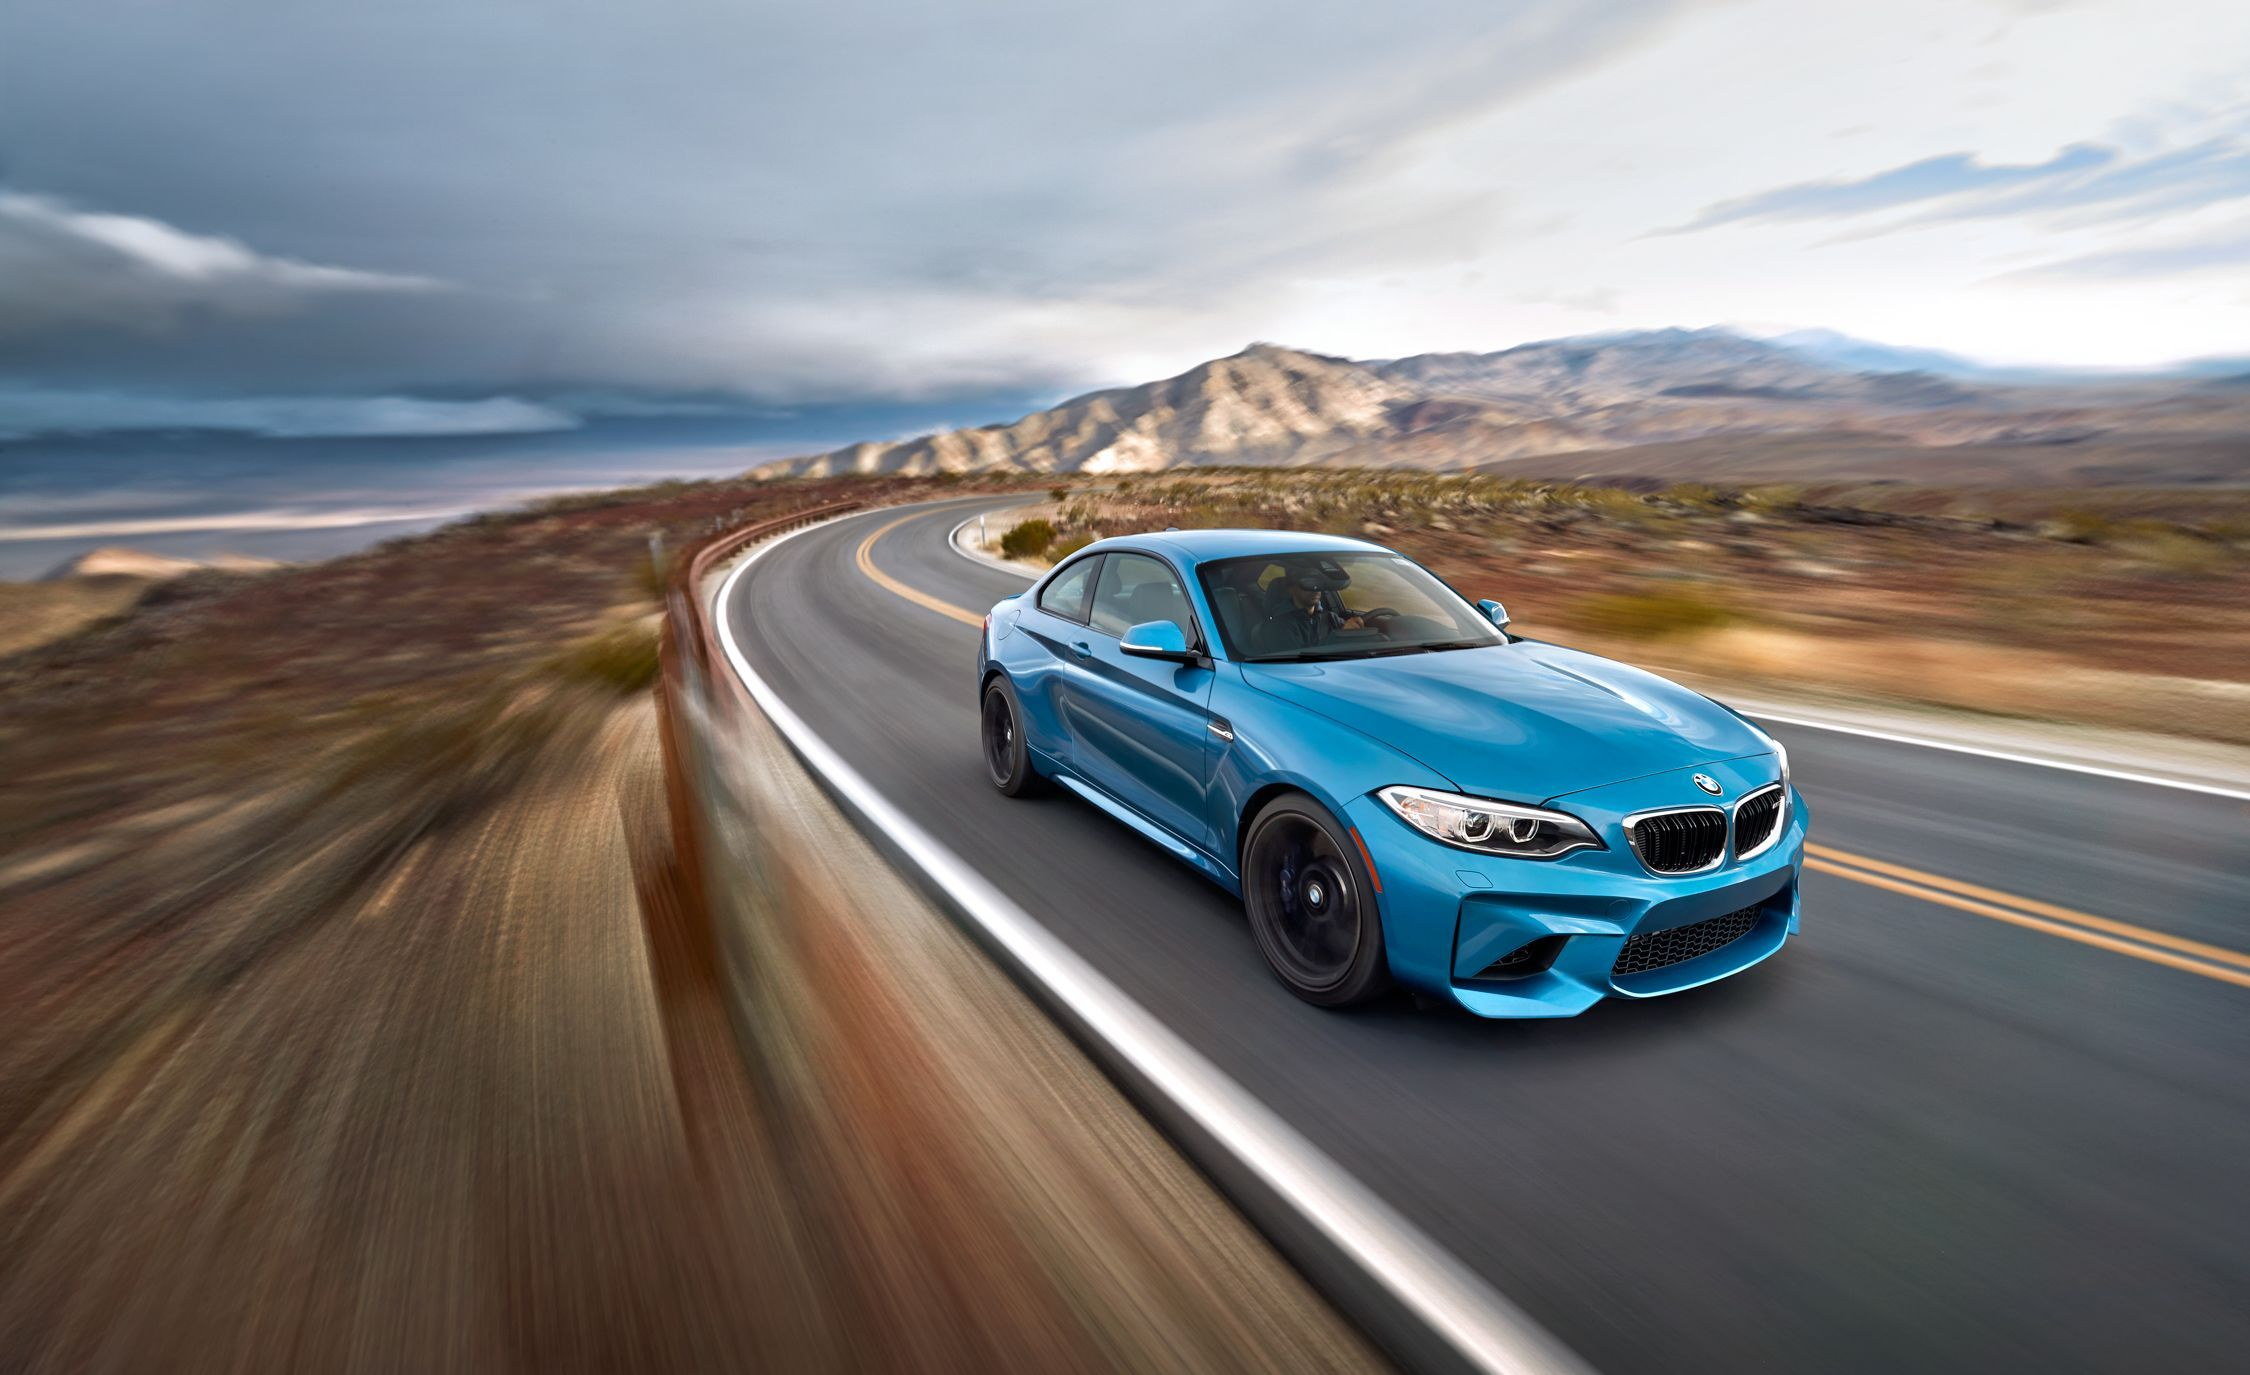

In [2]:
from PIL import Image
import requests
from io import BytesIO

#url = 'https://media-cdn.tripadvisor.com/media/photo-s/15/18/8b/2d/two-cars-admiring-the.jpg'
url = 'https://hips.hearstapps.com/hmg-prod/images/2016-bmw-m2-202-1585760824.jpg'
response = requests.get(url)
img = Image.open(BytesIO(response.content))
img

In [3]:
from PIL import Image
from torchvision import transforms

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])
input_tensor = preprocess(img)
input_batch = input_tensor.unsqueeze(0)#.cuda()

# inference
output = model(input_batch)

probabilities = torch.nn.functional.softmax(output[0], dim=0)

In [4]:
# Read the categories
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]
# Show top categories per image
top5_prob, top5_catid = torch.topk(probabilities, 5)
for i in range(top5_prob.size(0)):
    print(categories[top5_catid[i]], top5_prob[i].item())

sports car 0.5310037136077881
racer 0.4065282642841339
car wheel 0.025067951530218124
convertible 0.01220652274787426
beach wagon 0.0033741334918886423


## Integrated Gradients

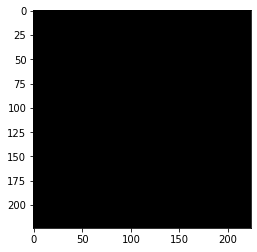

In [5]:
baseline = torch.zeros(224, 224, 3)
plt.imshow(baseline)

### Interpolate Images

In [6]:
m_steps=50
alphas = torch.linspace(0.0, 1.0, m_steps+1) # Generate m_steps intervals for integral_approximation() below.
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [7]:
def interpolate_images(baseline, image, alphas):
  image = image.permute(1, 2, 0)
  alphas_x = alphas.unsqueeze(1).unsqueeze(1).unsqueeze(1)
  baseline_x = baseline.unsqueeze(0)
  input_x = image.unsqueeze(0)
  delta = input_x - baseline_x
  images = baseline_x + alphas_x * delta
  return images

In [8]:
tensor_img = preprocess(img)

In [9]:
interpolated_imgs = interpolate_images(baseline, tensor_img, alphas)

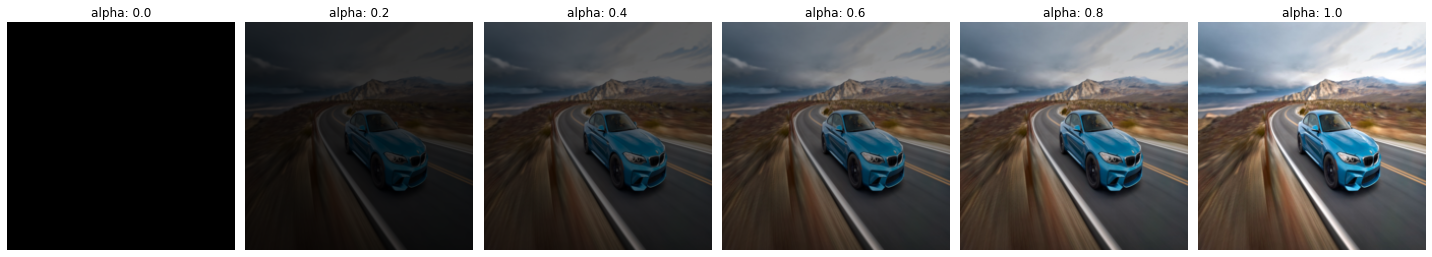

In [10]:
fig = plt.figure(figsize=(20, 20))

i = 0
for alpha, image in zip(alphas[0::10], interpolated_imgs[0::10]):
  i += 1
  plt.subplot(1, len(alphas[0::10]), i)
  plt.title(f'alpha: {alpha:.1f}')
  plt.imshow(image.numpy())
  plt.axis('off')

plt.tight_layout()

In [11]:
def compute_gradients(images, target_class_idx):
  if image.requires_grad is False: images.requires_grad = True
  logits = model(images)
  probs = torch.nn.functional.softmax(logits, dim=-1)[:, target_class_idx]
  grads = torch.autograd.grad(probs, images)[0]
  return grads

In [12]:
interpolated_imgs = interpolated_imgs.permute(0, 3, 2, 1)#.cuda()
path_gradients = compute_gradients(images=interpolated_imgs[0].unsqueeze(0),target_class_idx=818)

In [15]:
path_gradients.shape

torch.Size([1, 3, 224, 224])